# Kidney Disease Detection

#### Summary
* It is a classification problem
* Features include numerical values and categorical values
* Need to impute missing numerical values
* Need to impute missing categorical values
* Categorical features need to convert to numerical (get_dummies or DictVectorizer)
* DictVectorizer is introduced
* Pipeline build

#### dataset source
* The chronic kidney disease dataset contains both categorical and numeric features, but contains lots of missing values. The goal here is to predict who has chronic kidney disease given various blood indicators as features.</p>
* The dataset can be download from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease)

#### Package
* There are 3 self defined package: 
    * missing_values_table: check the percetage of missing values and turn it into a table
    * Categorical_Imputer: imputing categorical missing values using the most frequent
    * roc_auc: plot roc curve

## Library

In [143]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# Ipython tool for figsize
from IPython.core.pylabtools import figsize

# train test split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

# XGB
import xgboost as xgb

# cross_val_score
from sklearn.model_selection import cross_val_score

# DataframeMapper, CategoricalImputer
from sklearn_pandas import *
from sklearn_pandas import DataFrameMapper

# Imputer
from sklearn.preprocessing import *

# FeatureUnion
from sklearn.pipeline import FeatureUnion

# Function Transformer
from sklearn.preprocessing import FunctionTransformer

# ROC AUC
from sklearn.metrics import roc_auc_score, roc_curve

In [144]:
class Categorical_Imputer:
    """
    Imputing categorical data using the most frequent value
    """
    
    # instance attribute
    def __init__(self, strategy):
        self.strategy = strategy
        
    # instance method
    def fit_transform(self, df:'dataframe')->'dataframe':
        """
        Fill in missing categorical values using most frequent value
        """
        
        # instantiate CategoricalImputer
        imputer = CategoricalImputer()
        
        # convert array to dataframe
        df_filled = df.apply(lambda x: imputer.fit_transform(x), axis=0)
        
        # return filled dataframe
        return df_filled

# Function to calculate missing values by column
def missing_values_table(df):
   
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing missing values not equal to zero
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)  # round(2), keep 2 digits
    
    # Print some summary information
    print("Your slelected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

class roc_auc:
    """
    Calculate AUC score, Plot ROC curve
    """
    
    # instance attribute
    def __init__(self, y_test, y_pred_prob, model='model'):
        self.y_test = y_test
        self.y_pred_prob = y_pred_prob
        self.model = model
        
    # instance method
    def auc(self):
        """
        calculate auc score
        """
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        
        return auc_score
        
    # instance method
    def plot_roc(self):
        """
        plot roc curve
        """
        # AUC score
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        
        # fpr, tpr, threshold
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred_prob)
        
        # ROC curve plot
        _ = plt.plot([0, 1], [0, 1], 'k--')
        _ = plt.plot(fpr, tpr, label= self.model + ' Classifier (AUC = {: .2f})'.format(auc_score))
        _ = plt.xlabel('False Positive Rate')
        _ = plt.ylabel('True Positive Rate')
        _ = plt.legend(loc='lower right')
        _ = plt.title(self.model + ' Classifier ROC Curve')
        _ = plt.show()

# $\rm I.$ Data Preparation
In this section, we load the data, inspect missing values, convert data type, convert target to numerical

## Load Data

In [145]:
# set display columns
pd.set_option('display.max_columns', 30)

In [146]:
# load data
df = pd.read_csv('datasets/chronic_kidney_disease.csv', header=None, 
                 names=['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 
                           'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class'])

# head of df
df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,36,1.2,?,?,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,18,0.8,?,?,11.3,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,?,?,9.6,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,?,?,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
5,60,90,1.015,3,0,?,?,notpresent,notpresent,74,25,1.1,142,3.2,12.2,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,68,70,1.010,0,0,?,normal,notpresent,notpresent,100,54,24.0,104,4.0,12.4,36,?,?,no,no,no,good,no,no,ckd
7,24,?,1.015,2,4,normal,abnormal,notpresent,notpresent,410,31,1.1,?,?,12.4,44,6900,5,no,yes,no,good,yes,no,ckd
8,52,100,1.015,3,0,normal,abnormal,present,notpresent,138,60,1.9,?,?,10.8,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


Columns explain:
* age		-	age	
* bp		-	blood pressure
* sg		-	specific gravity
* al		-   albumin
* su		-	sugar
* rbc		-	red blood cells
* pc		-	pus cell
* pcc		-	pus cell clumps
* ba		-	bacteria
* bgr		-	blood glucose random
* bu		-	blood urea
* sc		-	serum creatinine
* sod		-	sodium
* pot		-	potassium
* hemo	    -	hemoglobin
* pcv		-	packed cell volume
* wc		-	white blood cell count
* rc		-	red blood cell count
* htn		-	hypertension
* dm		-	diabetes mellitus
* cad		-	coronary artery disease
* appet	    -	appetite
* pe		-	pedal edema
* ane		-	anemia
* class	    -	class	

## Exporatory Data Analysis

In [147]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     400 non-null    object
 1   bp      400 non-null    object
 2   sg      400 non-null    object
 3   al      400 non-null    object
 4   su      400 non-null    object
 5   rbc     400 non-null    object
 6   pc      400 non-null    object
 7   pcc     400 non-null    object
 8   ba      400 non-null    object
 9   bgr     400 non-null    object
 10  bu      400 non-null    object
 11  sc      400 non-null    object
 12  sod     400 non-null    object
 13  pot     400 non-null    object
 14  hemo    400 non-null    object
 15  pcv     400 non-null    object
 16  wc      400 non-null    object
 17  rc      400 non-null    object
 18  htn     400 non-null    object
 19  dm      400 non-null    object
 20  cad     400 non-null    object
 21  appet   400 non-null    object
 22  pe      400 non-null    ob

* All columns have dtype object, no matter categorial columns or numerical columns.
* We can see there are some missing values in ?, but pandas does not regard it as missing values.

#### Replace ? with Null

In [148]:
# repace ? values
df.replace('?', np.nan, inplace=True)

df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,121,36,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,18,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd
5,60,90,1.015,3,0,NaN,NaN,notpresent,notpresent,74,25,1.1,142,3.2,12.2,39,7800,4.4,yes,yes,no,good,yes,no,ckd
6,68,70,1.010,0,0,NaN,normal,notpresent,notpresent,100,54,24.0,104,4.0,12.4,36,NaN,NaN,no,no,no,good,no,no,ckd
7,24,NaN,1.015,2,4,normal,abnormal,notpresent,notpresent,410,31,1.1,NaN,NaN,12.4,44,6900,5,no,yes,no,good,yes,no,ckd
8,52,100,1.015,3,0,normal,abnormal,present,notpresent,138,60,1.9,NaN,NaN,10.8,33,9600,4.0,yes,yes,no,good,no,yes,ckd
9,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd


In [149]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     391 non-null    object
 1   bp      388 non-null    object
 2   sg      353 non-null    object
 3   al      354 non-null    object
 4   su      351 non-null    object
 5   rbc     248 non-null    object
 6   pc      335 non-null    object
 7   pcc     396 non-null    object
 8   ba      396 non-null    object
 9   bgr     356 non-null    object
 10  bu      381 non-null    object
 11  sc      383 non-null    object
 12  sod     313 non-null    object
 13  pot     312 non-null    object
 14  hemo    348 non-null    object
 15  pcv     329 non-null    object
 16  wc      294 non-null    object
 17  rc      269 non-null    object
 18  htn     398 non-null    object
 19  dm      398 non-null    object
 20  cad     398 non-null    object
 21  appet   399 non-null    object
 22  pe      399 non-null    ob

#### Check missing value percentage

In [150]:
# missing value table
missing_values_table(df)

Your slelected dataframe has 25 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
rbc,152,38.00
rc,131,32.75
wc,106,26.50
pot,88,22.00
sod,87,21.75
pcv,71,17.75
pc,65,16.25
hemo,52,13.00
su,49,12.25
sg,47,11.75


#### Convert to Numeric

In [151]:
# numerical columns
num_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

In [152]:
# categorical columns
cate_cols = df.columns.drop('class').drop(num_cols)
# display categorical columns
cate_cols

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [153]:
# convert numerical data 
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [154]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wc      294 non-null    float64
 17  rc      269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

#### Categorical Feature Unique Values

In [155]:
# categorical columns
cate_cols = df.columns.drop('class').drop(num_cols)
# display categorical columns
cate_cols

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [156]:
# check the number of unique values
df[cate_cols].apply(lambda x: x.nunique(), axis=0)

rbc      2
pc       2
pcc      2
ba       2
htn      2
dm       3
cad      2
appet    2
pe       2
ane      2
dtype: int64

In [157]:
# Problem found on df['dm'], string has extra space
df['dm'].unique()

array(['yes', 'no', ' yes', nan], dtype=object)

In [158]:
df['dm'].dtype

dtype('O')

In [159]:
# delete the space
df['dm'] = df['dm'].str.strip()

**If not delete this extra space, an error will be caused in pipeline due to X_train and X_test dimension not match!**

#### Convert target into 0 and 1

In [160]:
# convert categorical target to numerical
df['class'] = df['class'].apply(lambda x: 1 if x=='ckd' else 0)

# show the head of df['class']
df['class'].head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [161]:
# X and y
X = df.drop(columns=['class'])
y= df['class']

In X, we have missing values for both numerical and categorical data.

# $\rm II.$ Sklearn Imputer and Pandas Get Dummies Approach
In this section, we use sklearn Imputer to impute missing numerical and categorical missing values. We use pandas getdummies to turn categorical values into numerical values.

In [162]:
# load X and y
X = df.drop(columns=['class'])
y= df['class']

## Imputing Data

In [163]:
# define numerical imputer
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')

In [164]:
# imputing on numerical data
X[num_cols] = num_imputer.fit_transform(X[num_cols])

In [165]:
# define categorical imputer
cate_imputer = SimpleImputer(strategy="most_frequent") 

In [166]:
# imputing on categorical data
X[cate_cols] = cate_imputer.fit_transform(X[cate_cols])

In [167]:
# X head
X.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
5,60.0,90.0,1.015,3.0,0.0,normal,normal,notpresent,notpresent,74.0,25.0,1.1,142.0,3.2,12.2,39.0,7800.0,4.4,yes,yes,no,good,yes,no
6,68.0,70.0,1.010,0.0,0.0,normal,normal,notpresent,notpresent,100.0,54.0,24.0,104.0,4.0,12.4,36.0,8000.0,4.8,no,no,no,good,no,no
7,24.0,80.0,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,31.0,1.1,138.0,4.4,12.4,44.0,6900.0,5.0,no,yes,no,good,yes,no
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,60.0,1.9,138.0,4.4,10.8,33.0,9600.0,4.0,yes,yes,no,good,no,yes
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes


In [168]:
# missing value table
missing_values_table(X)

Your slelected dataframe has 24 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Get dummies
Turn categorical feature into numerical values

In [169]:
# Get dummies
X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

# X head
X.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,rbc_normal,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,1,1,0,0,1,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,1,1,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,1,1,0,0,0,1,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1,0,1,0,1,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,1,1,0,0,0,0,0,0,0,0


In [170]:
# X shape
X.shape

(400, 24)

## RandomForestClassifier

In [183]:
# Instantiate RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_cl = RandomForestClassifier()

In [184]:
# cross validation score
cv_scores = cross_val_score(rf_cl, X, y, scoring='roc_auc', cv=3)

In [185]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.999277108433735


## Fit Model

In [186]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [187]:
# fit the model
rf_cl.fit(X_train, y_train)

RandomForestClassifier()

## ROC AUC Curve

In [188]:
# predict on the test set
y_pred_prob = rf_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [189]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='RF')

In [190]:
# AUC score
ROC.auc()

0.9983703703703705

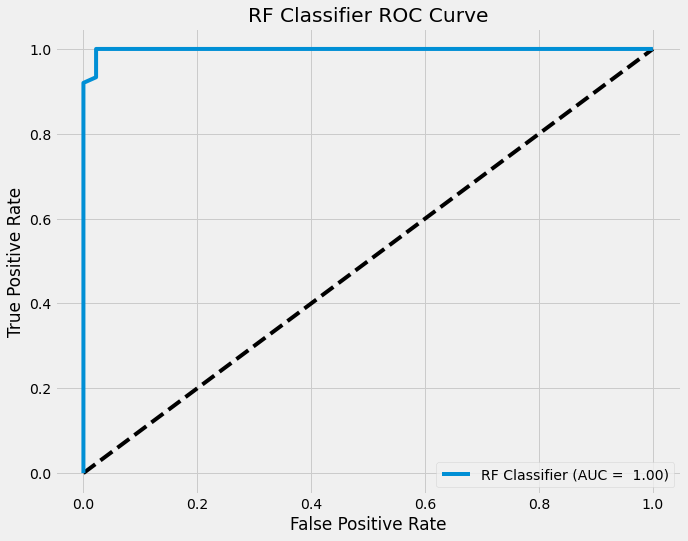

In [191]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

# XGBClassifier

In [192]:
# Instantiate XGBClassifier
xgb_cl = xgb.XGBClassifier()

In [193]:
# cross validation score
cv_scores = cross_val_score(xgb_cl, X, y, scoring='roc_auc', cv=3)

[12:03:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dpain\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\dpain\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\dpain\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when 

In [194]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.998156435264869


## Fit Model

In [195]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [196]:
# fit the model
xgb_cl.fit(X_train, y_train)

[12:03:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dpain\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\dpain\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## ROC AUC Curve

In [197]:
# predict on the test set
y_pred_prob = xgb_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [198]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='XGB')

In [199]:
# AUC score
ROC.auc()

0.9961481481481482

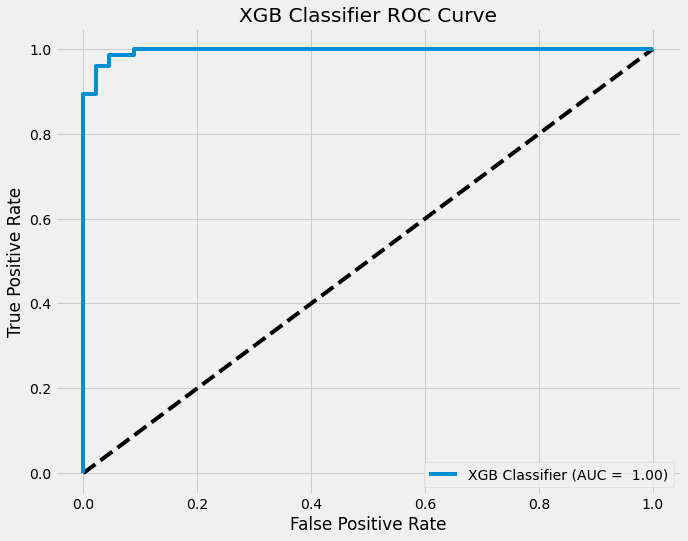

In [200]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

## Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

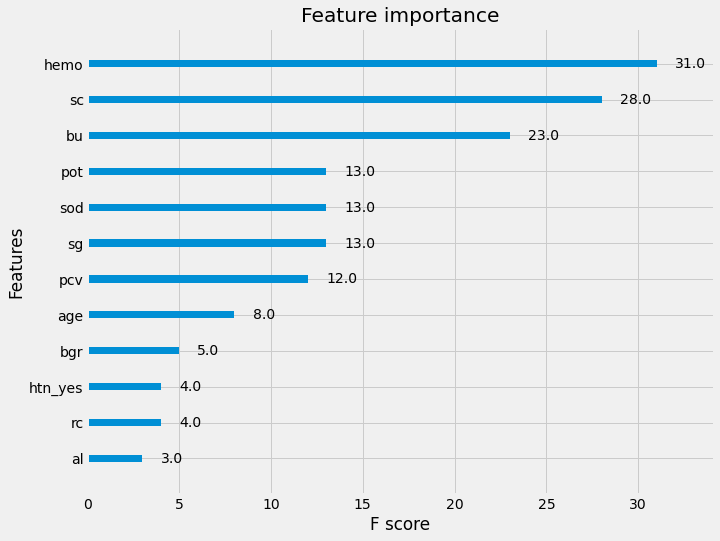

In [201]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot feature importance
xgb.plot_importance(xgb_cl)

# CatBoostClassifier

In [202]:
# Instantiate CatBoostClassifier
from catboost import CatBoostClassifier
cbc_cl = CatBoostClassifier()

In [203]:
# cross validation score
cv_scores = cross_val_score(cbc_cl, X, y, scoring='roc_auc', cv=3)

Learning rate set to 0.005853
0:	learn: 0.6833620	total: 164ms	remaining: 2m 43s
1:	learn: 0.6744971	total: 166ms	remaining: 1m 22s
2:	learn: 0.6649067	total: 169ms	remaining: 56s
3:	learn: 0.6571738	total: 171ms	remaining: 42.5s
4:	learn: 0.6487533	total: 172ms	remaining: 34.2s
5:	learn: 0.6403155	total: 173ms	remaining: 28.7s
6:	learn: 0.6312621	total: 175ms	remaining: 24.8s
7:	learn: 0.6230431	total: 176ms	remaining: 21.8s
8:	learn: 0.6159905	total: 178ms	remaining: 19.5s
9:	learn: 0.6072801	total: 179ms	remaining: 17.8s
10:	learn: 0.5992802	total: 181ms	remaining: 16.2s
11:	learn: 0.5918273	total: 182ms	remaining: 15s
12:	learn: 0.5841777	total: 183ms	remaining: 13.9s
13:	learn: 0.5755661	total: 184ms	remaining: 13s
14:	learn: 0.5672387	total: 186ms	remaining: 12.2s
15:	learn: 0.5600184	total: 188ms	remaining: 11.6s
16:	learn: 0.5520261	total: 189ms	remaining: 10.9s
17:	learn: 0.5445106	total: 190ms	remaining: 10.4s
18:	learn: 0.5381520	total: 191ms	remaining: 9.87s
19:	learn: 0.53

302:	learn: 0.0505208	total: 508ms	remaining: 1.17s
303:	learn: 0.0502356	total: 509ms	remaining: 1.17s
304:	learn: 0.0499595	total: 510ms	remaining: 1.16s
305:	learn: 0.0496741	total: 511ms	remaining: 1.16s
306:	learn: 0.0493913	total: 513ms	remaining: 1.16s
307:	learn: 0.0491268	total: 514ms	remaining: 1.15s
308:	learn: 0.0489105	total: 515ms	remaining: 1.15s
309:	learn: 0.0486784	total: 516ms	remaining: 1.15s
310:	learn: 0.0484312	total: 517ms	remaining: 1.15s
311:	learn: 0.0482401	total: 518ms	remaining: 1.14s
312:	learn: 0.0481036	total: 519ms	remaining: 1.14s
313:	learn: 0.0478783	total: 521ms	remaining: 1.14s
314:	learn: 0.0475800	total: 522ms	remaining: 1.14s
315:	learn: 0.0473189	total: 523ms	remaining: 1.13s
316:	learn: 0.0471530	total: 525ms	remaining: 1.13s
317:	learn: 0.0469350	total: 526ms	remaining: 1.13s
318:	learn: 0.0467217	total: 528ms	remaining: 1.13s
319:	learn: 0.0465090	total: 529ms	remaining: 1.12s
320:	learn: 0.0462512	total: 530ms	remaining: 1.12s
321:	learn: 

614:	learn: 0.0168968	total: 850ms	remaining: 532ms
615:	learn: 0.0168457	total: 851ms	remaining: 531ms
616:	learn: 0.0168028	total: 852ms	remaining: 529ms
617:	learn: 0.0167684	total: 854ms	remaining: 528ms
618:	learn: 0.0167059	total: 855ms	remaining: 526ms
619:	learn: 0.0166591	total: 856ms	remaining: 525ms
620:	learn: 0.0166214	total: 857ms	remaining: 523ms
621:	learn: 0.0165733	total: 858ms	remaining: 522ms
622:	learn: 0.0165350	total: 860ms	remaining: 520ms
623:	learn: 0.0164703	total: 861ms	remaining: 519ms
624:	learn: 0.0164398	total: 862ms	remaining: 517ms
625:	learn: 0.0163981	total: 863ms	remaining: 516ms
626:	learn: 0.0163615	total: 864ms	remaining: 514ms
627:	learn: 0.0163400	total: 866ms	remaining: 513ms
628:	learn: 0.0162919	total: 868ms	remaining: 512ms
629:	learn: 0.0162607	total: 870ms	remaining: 511ms
630:	learn: 0.0162335	total: 872ms	remaining: 510ms
631:	learn: 0.0161835	total: 873ms	remaining: 508ms
632:	learn: 0.0161457	total: 874ms	remaining: 507ms
633:	learn: 

892:	learn: 0.0093975	total: 1.18s	remaining: 141ms
893:	learn: 0.0093846	total: 1.18s	remaining: 140ms
894:	learn: 0.0093668	total: 1.18s	remaining: 139ms
895:	learn: 0.0093510	total: 1.18s	remaining: 137ms
896:	learn: 0.0093349	total: 1.19s	remaining: 136ms
897:	learn: 0.0093196	total: 1.19s	remaining: 135ms
898:	learn: 0.0093035	total: 1.19s	remaining: 133ms
899:	learn: 0.0092912	total: 1.19s	remaining: 132ms
900:	learn: 0.0092748	total: 1.19s	remaining: 131ms
901:	learn: 0.0092533	total: 1.19s	remaining: 129ms
902:	learn: 0.0092407	total: 1.19s	remaining: 128ms
903:	learn: 0.0092273	total: 1.19s	remaining: 127ms
904:	learn: 0.0092110	total: 1.19s	remaining: 125ms
905:	learn: 0.0091901	total: 1.2s	remaining: 124ms
906:	learn: 0.0091736	total: 1.2s	remaining: 123ms
907:	learn: 0.0091590	total: 1.2s	remaining: 121ms
908:	learn: 0.0091431	total: 1.2s	remaining: 120ms
909:	learn: 0.0091263	total: 1.2s	remaining: 119ms
910:	learn: 0.0091085	total: 1.2s	remaining: 117ms
911:	learn: 0.0090

173:	learn: 0.1004056	total: 187ms	remaining: 889ms
174:	learn: 0.0998392	total: 189ms	remaining: 890ms
175:	learn: 0.0990036	total: 190ms	remaining: 890ms
176:	learn: 0.0982871	total: 191ms	remaining: 889ms
177:	learn: 0.0975186	total: 192ms	remaining: 889ms
178:	learn: 0.0967000	total: 194ms	remaining: 888ms
179:	learn: 0.0957595	total: 195ms	remaining: 887ms
180:	learn: 0.0950010	total: 196ms	remaining: 886ms
181:	learn: 0.0942895	total: 197ms	remaining: 885ms
182:	learn: 0.0933719	total: 198ms	remaining: 883ms
183:	learn: 0.0926751	total: 199ms	remaining: 882ms
184:	learn: 0.0919088	total: 200ms	remaining: 883ms
185:	learn: 0.0911104	total: 202ms	remaining: 883ms
186:	learn: 0.0905497	total: 203ms	remaining: 884ms
187:	learn: 0.0898331	total: 205ms	remaining: 884ms
188:	learn: 0.0892487	total: 206ms	remaining: 885ms
189:	learn: 0.0885837	total: 208ms	remaining: 886ms
190:	learn: 0.0879705	total: 209ms	remaining: 886ms
191:	learn: 0.0874241	total: 210ms	remaining: 885ms
192:	learn: 

466:	learn: 0.0229867	total: 525ms	remaining: 599ms
467:	learn: 0.0229093	total: 527ms	remaining: 599ms
468:	learn: 0.0228173	total: 528ms	remaining: 598ms
469:	learn: 0.0227417	total: 529ms	remaining: 596ms
470:	learn: 0.0226520	total: 530ms	remaining: 595ms
471:	learn: 0.0225761	total: 531ms	remaining: 594ms
472:	learn: 0.0225128	total: 532ms	remaining: 593ms
473:	learn: 0.0224437	total: 534ms	remaining: 592ms
474:	learn: 0.0223803	total: 535ms	remaining: 591ms
475:	learn: 0.0223001	total: 536ms	remaining: 590ms
476:	learn: 0.0222483	total: 537ms	remaining: 589ms
477:	learn: 0.0221803	total: 539ms	remaining: 588ms
478:	learn: 0.0221012	total: 540ms	remaining: 587ms
479:	learn: 0.0220052	total: 541ms	remaining: 586ms
480:	learn: 0.0219319	total: 542ms	remaining: 585ms
481:	learn: 0.0218687	total: 544ms	remaining: 584ms
482:	learn: 0.0217994	total: 545ms	remaining: 583ms
483:	learn: 0.0217219	total: 547ms	remaining: 583ms
484:	learn: 0.0216618	total: 548ms	remaining: 582ms
485:	learn: 

628:	learn: 0.0145941	total: 703ms	remaining: 415ms
629:	learn: 0.0145554	total: 704ms	remaining: 414ms
630:	learn: 0.0145167	total: 706ms	remaining: 413ms
631:	learn: 0.0144859	total: 707ms	remaining: 412ms
632:	learn: 0.0144398	total: 708ms	remaining: 410ms
633:	learn: 0.0144017	total: 709ms	remaining: 409ms
634:	learn: 0.0143630	total: 710ms	remaining: 408ms
635:	learn: 0.0143289	total: 711ms	remaining: 407ms
636:	learn: 0.0143020	total: 712ms	remaining: 406ms
637:	learn: 0.0142721	total: 714ms	remaining: 405ms
638:	learn: 0.0142354	total: 715ms	remaining: 404ms
639:	learn: 0.0141907	total: 717ms	remaining: 403ms
640:	learn: 0.0141555	total: 718ms	remaining: 402ms
641:	learn: 0.0141255	total: 720ms	remaining: 401ms
642:	learn: 0.0141019	total: 721ms	remaining: 400ms
643:	learn: 0.0140745	total: 722ms	remaining: 399ms
644:	learn: 0.0140492	total: 723ms	remaining: 398ms
645:	learn: 0.0140098	total: 724ms	remaining: 397ms
646:	learn: 0.0139780	total: 725ms	remaining: 396ms
647:	learn: 

869:	learn: 0.0088561	total: 1.04s	remaining: 155ms
870:	learn: 0.0088366	total: 1.04s	remaining: 154ms
871:	learn: 0.0088258	total: 1.04s	remaining: 153ms
872:	learn: 0.0088126	total: 1.04s	remaining: 152ms
873:	learn: 0.0087941	total: 1.04s	remaining: 151ms
874:	learn: 0.0087786	total: 1.05s	remaining: 149ms
875:	learn: 0.0087635	total: 1.05s	remaining: 148ms
876:	learn: 0.0087532	total: 1.05s	remaining: 147ms
877:	learn: 0.0087359	total: 1.05s	remaining: 146ms
878:	learn: 0.0087182	total: 1.05s	remaining: 145ms
879:	learn: 0.0087032	total: 1.05s	remaining: 144ms
880:	learn: 0.0086804	total: 1.05s	remaining: 142ms
881:	learn: 0.0086673	total: 1.06s	remaining: 141ms
882:	learn: 0.0086508	total: 1.06s	remaining: 140ms
883:	learn: 0.0086399	total: 1.06s	remaining: 139ms
884:	learn: 0.0086238	total: 1.06s	remaining: 138ms
885:	learn: 0.0086076	total: 1.06s	remaining: 137ms
886:	learn: 0.0085950	total: 1.07s	remaining: 136ms
887:	learn: 0.0085812	total: 1.07s	remaining: 135ms
888:	learn: 

147:	learn: 0.1296906	total: 213ms	remaining: 1.22s
148:	learn: 0.1285925	total: 218ms	remaining: 1.24s
149:	learn: 0.1270871	total: 220ms	remaining: 1.25s
150:	learn: 0.1254753	total: 223ms	remaining: 1.25s
151:	learn: 0.1244364	total: 226ms	remaining: 1.26s
152:	learn: 0.1233811	total: 228ms	remaining: 1.26s
153:	learn: 0.1224415	total: 230ms	remaining: 1.26s
154:	learn: 0.1212872	total: 232ms	remaining: 1.26s
155:	learn: 0.1202007	total: 233ms	remaining: 1.26s
156:	learn: 0.1189644	total: 235ms	remaining: 1.26s
157:	learn: 0.1176612	total: 236ms	remaining: 1.26s
158:	learn: 0.1166520	total: 238ms	remaining: 1.26s
159:	learn: 0.1158471	total: 240ms	remaining: 1.26s
160:	learn: 0.1146277	total: 242ms	remaining: 1.26s
161:	learn: 0.1136576	total: 245ms	remaining: 1.26s
162:	learn: 0.1127773	total: 247ms	remaining: 1.27s
163:	learn: 0.1117808	total: 248ms	remaining: 1.26s
164:	learn: 0.1107969	total: 249ms	remaining: 1.26s
165:	learn: 0.1098101	total: 251ms	remaining: 1.26s
166:	learn: 

348:	learn: 0.0353061	total: 545ms	remaining: 1.01s
349:	learn: 0.0350865	total: 547ms	remaining: 1.01s
350:	learn: 0.0349787	total: 548ms	remaining: 1.01s
351:	learn: 0.0348190	total: 550ms	remaining: 1.01s
352:	learn: 0.0346682	total: 552ms	remaining: 1.01s
353:	learn: 0.0344675	total: 553ms	remaining: 1.01s
354:	learn: 0.0342895	total: 554ms	remaining: 1.01s
355:	learn: 0.0340870	total: 555ms	remaining: 1s
356:	learn: 0.0338947	total: 556ms	remaining: 1s
357:	learn: 0.0337204	total: 557ms	remaining: 999ms
358:	learn: 0.0335703	total: 559ms	remaining: 998ms
359:	learn: 0.0334633	total: 560ms	remaining: 996ms
360:	learn: 0.0333028	total: 563ms	remaining: 996ms
361:	learn: 0.0331483	total: 564ms	remaining: 994ms
362:	learn: 0.0330081	total: 567ms	remaining: 995ms
363:	learn: 0.0328992	total: 569ms	remaining: 994ms
364:	learn: 0.0327821	total: 570ms	remaining: 992ms
365:	learn: 0.0326308	total: 572ms	remaining: 991ms
366:	learn: 0.0324981	total: 574ms	remaining: 990ms
367:	learn: 0.0323

548:	learn: 0.0175072	total: 871ms	remaining: 716ms
549:	learn: 0.0174559	total: 873ms	remaining: 714ms
550:	learn: 0.0174020	total: 874ms	remaining: 712ms
551:	learn: 0.0173552	total: 876ms	remaining: 711ms
552:	learn: 0.0173045	total: 878ms	remaining: 709ms
553:	learn: 0.0172525	total: 879ms	remaining: 707ms
554:	learn: 0.0172000	total: 880ms	remaining: 705ms
555:	learn: 0.0171621	total: 881ms	remaining: 704ms
556:	learn: 0.0171315	total: 883ms	remaining: 702ms
557:	learn: 0.0170695	total: 884ms	remaining: 700ms
558:	learn: 0.0170319	total: 885ms	remaining: 698ms
559:	learn: 0.0169920	total: 887ms	remaining: 697ms
560:	learn: 0.0169567	total: 889ms	remaining: 695ms
561:	learn: 0.0168970	total: 891ms	remaining: 694ms
562:	learn: 0.0168631	total: 893ms	remaining: 693ms
563:	learn: 0.0168289	total: 895ms	remaining: 692ms
564:	learn: 0.0167824	total: 897ms	remaining: 691ms
565:	learn: 0.0167239	total: 899ms	remaining: 689ms
566:	learn: 0.0166977	total: 901ms	remaining: 688ms
567:	learn: 

737:	learn: 0.0110458	total: 1.19s	remaining: 421ms
738:	learn: 0.0110210	total: 1.19s	remaining: 419ms
739:	learn: 0.0109955	total: 1.19s	remaining: 418ms
740:	learn: 0.0109736	total: 1.19s	remaining: 416ms
741:	learn: 0.0109603	total: 1.19s	remaining: 414ms
742:	learn: 0.0109418	total: 1.19s	remaining: 413ms
743:	learn: 0.0108952	total: 1.19s	remaining: 411ms
744:	learn: 0.0108804	total: 1.2s	remaining: 409ms
745:	learn: 0.0108548	total: 1.2s	remaining: 408ms
746:	learn: 0.0108292	total: 1.2s	remaining: 406ms
747:	learn: 0.0108003	total: 1.2s	remaining: 405ms
748:	learn: 0.0107712	total: 1.2s	remaining: 404ms
749:	learn: 0.0107546	total: 1.21s	remaining: 402ms
750:	learn: 0.0107330	total: 1.21s	remaining: 400ms
751:	learn: 0.0107076	total: 1.21s	remaining: 399ms
752:	learn: 0.0106846	total: 1.21s	remaining: 397ms
753:	learn: 0.0106666	total: 1.21s	remaining: 395ms
754:	learn: 0.0106480	total: 1.21s	remaining: 394ms
755:	learn: 0.0106209	total: 1.22s	remaining: 392ms
756:	learn: 0.010

903:	learn: 0.0080396	total: 1.5s	remaining: 160ms
904:	learn: 0.0080269	total: 1.51s	remaining: 158ms
905:	learn: 0.0080164	total: 1.51s	remaining: 157ms
906:	learn: 0.0080017	total: 1.51s	remaining: 155ms
907:	learn: 0.0079897	total: 1.51s	remaining: 154ms
908:	learn: 0.0079789	total: 1.52s	remaining: 152ms
909:	learn: 0.0079648	total: 1.52s	remaining: 150ms
910:	learn: 0.0079535	total: 1.52s	remaining: 149ms
911:	learn: 0.0079351	total: 1.52s	remaining: 147ms
912:	learn: 0.0079255	total: 1.52s	remaining: 145ms
913:	learn: 0.0079164	total: 1.52s	remaining: 144ms
914:	learn: 0.0079068	total: 1.53s	remaining: 142ms
915:	learn: 0.0078933	total: 1.53s	remaining: 140ms
916:	learn: 0.0078764	total: 1.53s	remaining: 139ms
917:	learn: 0.0078668	total: 1.53s	remaining: 137ms
918:	learn: 0.0078536	total: 1.53s	remaining: 135ms
919:	learn: 0.0078417	total: 1.54s	remaining: 134ms
920:	learn: 0.0078316	total: 1.54s	remaining: 132ms
921:	learn: 0.0078192	total: 1.54s	remaining: 130ms
922:	learn: 0

In [204]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 0.9996796710652133


## Fit Model

In [205]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [206]:
# fit the model
cbc_cl.fit(X_train, y_train)

Learning rate set to 0.005982
0:	learn: 0.6818621	total: 1.38ms	remaining: 1.38s
1:	learn: 0.6734495	total: 2.69ms	remaining: 1.34s
2:	learn: 0.6635224	total: 3.96ms	remaining: 1.32s
3:	learn: 0.6552197	total: 5.34ms	remaining: 1.33s
4:	learn: 0.6456054	total: 6.89ms	remaining: 1.37s
5:	learn: 0.6375213	total: 8.98ms	remaining: 1.49s
6:	learn: 0.6284100	total: 10.6ms	remaining: 1.5s
7:	learn: 0.6201377	total: 12.2ms	remaining: 1.51s
8:	learn: 0.6129724	total: 13ms	remaining: 1.43s
9:	learn: 0.6038016	total: 14.8ms	remaining: 1.46s
10:	learn: 0.5953104	total: 16.2ms	remaining: 1.45s
11:	learn: 0.5871101	total: 17.8ms	remaining: 1.47s
12:	learn: 0.5804819	total: 19.3ms	remaining: 1.47s
13:	learn: 0.5708344	total: 21.1ms	remaining: 1.48s
14:	learn: 0.5628463	total: 22.5ms	remaining: 1.48s
15:	learn: 0.5565945	total: 23.8ms	remaining: 1.46s
16:	learn: 0.5482055	total: 25ms	remaining: 1.45s
17:	learn: 0.5407740	total: 26.1ms	remaining: 1.43s
18:	learn: 0.5332605	total: 27.4ms	remaining: 1.4

284:	learn: 0.0463079	total: 333ms	remaining: 835ms
285:	learn: 0.0460280	total: 334ms	remaining: 835ms
286:	learn: 0.0458063	total: 336ms	remaining: 834ms
287:	learn: 0.0456030	total: 337ms	remaining: 833ms
288:	learn: 0.0453438	total: 338ms	remaining: 832ms
289:	learn: 0.0451208	total: 339ms	remaining: 830ms
290:	learn: 0.0448128	total: 340ms	remaining: 830ms
291:	learn: 0.0445569	total: 342ms	remaining: 828ms
292:	learn: 0.0444029	total: 343ms	remaining: 827ms
293:	learn: 0.0441275	total: 344ms	remaining: 826ms
294:	learn: 0.0439079	total: 345ms	remaining: 825ms
295:	learn: 0.0437061	total: 347ms	remaining: 824ms
296:	learn: 0.0434503	total: 348ms	remaining: 823ms
297:	learn: 0.0432197	total: 349ms	remaining: 823ms
298:	learn: 0.0429586	total: 351ms	remaining: 822ms
299:	learn: 0.0427301	total: 352ms	remaining: 821ms
300:	learn: 0.0425437	total: 353ms	remaining: 820ms
301:	learn: 0.0424134	total: 354ms	remaining: 819ms
302:	learn: 0.0421419	total: 356ms	remaining: 818ms
303:	learn: 

447:	learn: 0.0228805	total: 516ms	remaining: 635ms
448:	learn: 0.0228358	total: 517ms	remaining: 635ms
449:	learn: 0.0227444	total: 518ms	remaining: 634ms
450:	learn: 0.0226575	total: 520ms	remaining: 632ms
451:	learn: 0.0225692	total: 521ms	remaining: 631ms
452:	learn: 0.0225046	total: 522ms	remaining: 630ms
453:	learn: 0.0224225	total: 523ms	remaining: 629ms
454:	learn: 0.0223590	total: 524ms	remaining: 628ms
455:	learn: 0.0222705	total: 526ms	remaining: 628ms
456:	learn: 0.0222091	total: 528ms	remaining: 627ms
457:	learn: 0.0221277	total: 530ms	remaining: 627ms
458:	learn: 0.0220472	total: 531ms	remaining: 626ms
459:	learn: 0.0219599	total: 532ms	remaining: 625ms
460:	learn: 0.0218823	total: 534ms	remaining: 624ms
461:	learn: 0.0218182	total: 535ms	remaining: 623ms
462:	learn: 0.0217420	total: 536ms	remaining: 622ms
463:	learn: 0.0216880	total: 537ms	remaining: 620ms
464:	learn: 0.0216265	total: 538ms	remaining: 619ms
465:	learn: 0.0215364	total: 539ms	remaining: 618ms
466:	learn: 

750:	learn: 0.0103502	total: 855ms	remaining: 283ms
751:	learn: 0.0103342	total: 856ms	remaining: 282ms
752:	learn: 0.0103151	total: 857ms	remaining: 281ms
753:	learn: 0.0102987	total: 858ms	remaining: 280ms
754:	learn: 0.0102803	total: 859ms	remaining: 279ms
755:	learn: 0.0102642	total: 861ms	remaining: 278ms
756:	learn: 0.0102461	total: 862ms	remaining: 277ms
757:	learn: 0.0102198	total: 863ms	remaining: 275ms
758:	learn: 0.0101907	total: 864ms	remaining: 274ms
759:	learn: 0.0101739	total: 865ms	remaining: 273ms
760:	learn: 0.0101541	total: 866ms	remaining: 272ms
761:	learn: 0.0101316	total: 868ms	remaining: 271ms
762:	learn: 0.0101053	total: 869ms	remaining: 270ms
763:	learn: 0.0100796	total: 871ms	remaining: 269ms
764:	learn: 0.0100655	total: 873ms	remaining: 268ms
765:	learn: 0.0100424	total: 874ms	remaining: 267ms
766:	learn: 0.0100229	total: 875ms	remaining: 266ms
767:	learn: 0.0100025	total: 876ms	remaining: 265ms
768:	learn: 0.0099773	total: 877ms	remaining: 263ms
769:	learn: 

992:	learn: 0.0067110	total: 1.2s	remaining: 8.43ms
993:	learn: 0.0067016	total: 1.2s	remaining: 7.22ms
994:	learn: 0.0066907	total: 1.2s	remaining: 6.02ms
995:	learn: 0.0066816	total: 1.2s	remaining: 4.82ms
996:	learn: 0.0066710	total: 1.2s	remaining: 3.61ms
997:	learn: 0.0066648	total: 1.2s	remaining: 2.41ms
998:	learn: 0.0066536	total: 1.2s	remaining: 1.2ms
999:	learn: 0.0066431	total: 1.2s	remaining: 0us


## ROC AUC Curve

In [207]:
# predict on the test set
y_pred_prob = cbc_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [208]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='CatBoostClassifier')

In [209]:
# AUC score
ROC.auc()

0.9988148148148148

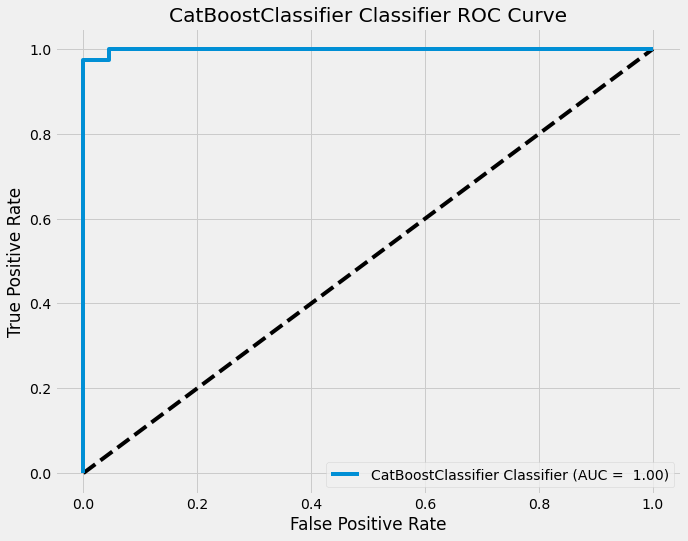

In [210]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()

In [212]:
!pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 7.2 MB/s eta 0:00:00


# LGBMClassifier

In [214]:
# Instantiate LGBMClassifier
from lightgbm import LGBMClassifier
lgbm_cl = LGBMClassifier()

In [215]:
# cross validation score
cv_scores = cross_val_score(lgbm_cl, X, y, scoring='roc_auc', cv=3)

In [216]:
# print out the mean cross validation score
print('3-Fold AUC: {}'.format(np.mean(cv_scores)))

3-Fold AUC: 1.0


## Fit Model

In [217]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [218]:
# fit the model
lgbm_cl.fit(X_train, y_train)

LGBMClassifier()

## ROC AUC Curve

In [219]:
# predict on the test set
y_pred_prob = lgbm_cl.predict_proba(X_test)[:, 1] # [:, 1]: the second value is the probability for 1

In [220]:
# instantiate a roc_auc object
ROC = roc_auc(y_test, y_pred_prob, model='CatBoostClassifier')

In [221]:
# AUC score
ROC.auc()

0.9991111111111112

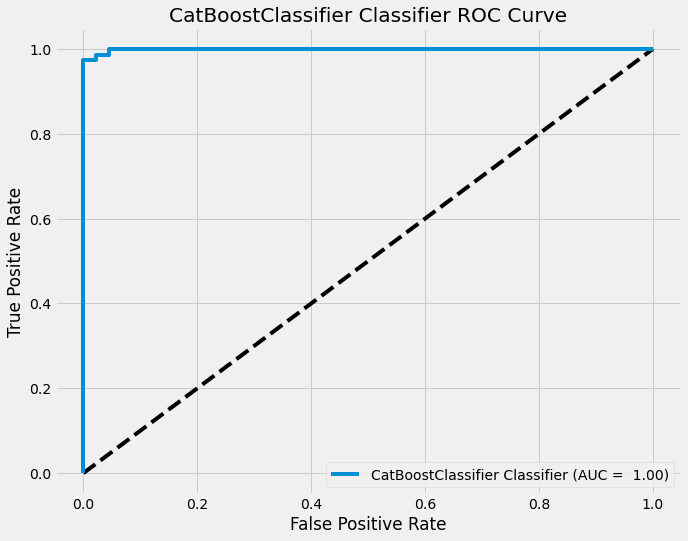

In [222]:
# set figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot roc
ROC.plot_roc()